In [10]:
using DrWatson
@quickactivate :NARMAXExperiments

In [11]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using FFTW
using Parameters
import ProgressMeter
using CSV
using DataFrames
using MAT
gr()

Plots.GRBackend()

In [16]:
import ReactiveMP.messageout

## Load generated signal

In [13]:
mat_ils = matread("../experiments/results/results-NARMAX_ILS_stde0.05_pol3_delays4_D22_degree3_r2.mat")


Dict{String, Any} with 2 entries:
  "RMS_sim" => [0.0674145 0.0535288 0.0525547 0.0521735]
  "RMS_prd" => [NaN 0.0540872 0.0520495 0.0518238]

In [14]:
# Load from .mat file
mat_data = matread("../datasets/verification/realizations/NARMAXsignal_stde0.05_degree3_delays4_D22_r9.mat")

train_size = 1000
test_size = 1000

# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:train_size) .+ transient

# Length of testing signal
ix_tst = collect(1:test_size) .+ transient;

# Extract data sets
input_trn = mat_data["uTrain"][ix_trn]
noise_trn = mat_data["eTrain"][ix_trn]
output_trn = mat_data["yTrain"][ix_trn]
T_trn = length(input_trn)

input_tst = mat_data["uTest"][ix_tst]
noise_tst = mat_data["eTest"][ix_tst]
output_tst = mat_data["yTest"][ix_tst]
T_tst = length(input_tst)

# System parameters
η_true = mat_data["system"]["theta"][:]
τ_true = inv(mat_data["options"]["stde"]^2);

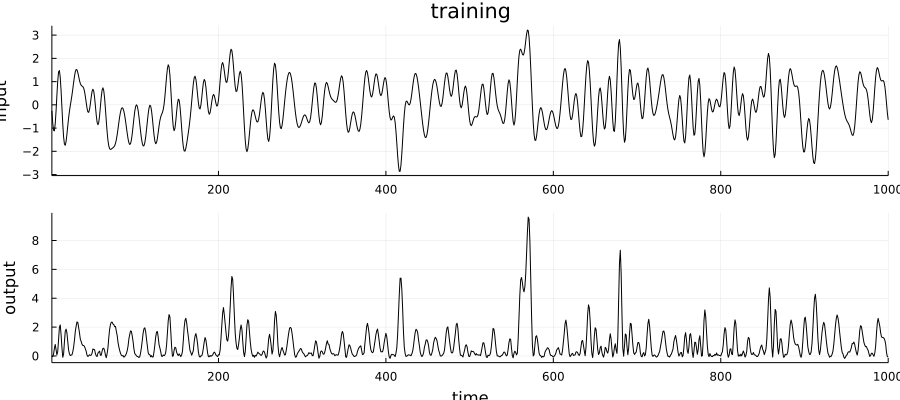

In [15]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1), xlims=(1, train_size))

### prepare training/test sets 

In [17]:
delay_y, delay_u, delay_e = Int.(ones(3))
order_u = delay_u + 1
poly_order = 3

3

In [18]:
# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# Generate validation data
observations_prev, observations = ssm(output_tst, delay_y)
controls = ssm(input_tst, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [19]:
function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (u, y, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([u; y; h[1:end]])
    end 
end

const phi_ = phi()

#1 (generic function with 1 method)

In [20]:
options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)

full_order = length(ϕ(zeros(delay_y+delay_e+order_u), options))


22

In [21]:
# Nonlinear MAX model definition
@model function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_e, order)
        
    S = shift(delay_e); c = zeros(delay_e); c[1] = 1.0;
    
    # initialize variables
    w  = randomvar()
    h  = randomvar(n-1)
    e  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)
        
    # priors
    w  ~ GammaShapeRate(w_prior[1], w_prior[2])
    η  ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ  ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    # initial
    h_0  ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    z[1] ~ NonlinearNode(h_0) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi_, y_prev[1], u[1])}
    ẑ[1] ~ AR(z[1], η, τ)
    
    b = zeros(order); b[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n-1
        
        e[t] ~ NormalMeanPrecision(0.0, w)
        h[t] ~ S*h_prev + c*e[t]
        y[t] ~ dot(ẑ[t], b) + e[t]
    
        h_prev = h[t]
        z[t+1] ~ NonlinearNode(h_prev) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi_, y_prev[t+1], u[t+1])}
        ẑ[t+1] ~ AR(z[t+1], η, τ)
    end
    
    e[n] ~ NormalMeanPrecision(0.0, w)
    y[n] ~ dot(ẑ[n], b) + e[n]

    return w, h, η, τ, z, ẑ, y
end

In [22]:
coefs_mean = zeros(full_order);
coefs_precision = diageye(full_order);

In [23]:
w_prior, τ_prior =  GammaShapeRate(1.0, 1.0), GammaShapeRate(1e2, 1.0)
h_prior, η_prior = MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e)),  MvNormalMeanPrecision(coefs_mean, coefs_precision)

(MvNormalMeanPrecision(
μ: [0.0]
Λ: [1.0;;]
)
, MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Λ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
)

In [24]:
narmax_imarginals = (h = h_prior,
                     w = w_prior,
                     τ = τ_prior,
                     η = η_prior);

In [25]:
narmax_imessages = (e = NormalMeanPrecision(0.0, var(Y_train)), );

In [26]:
@meta function narmax_meta(artype, order, stype)
    AR(ẑ, η, τ) -> ARMeta(artype, order, stype)
end

narmax_meta (generic function with 1 method)

In [27]:
narmax_constraints = @constraints begin
    q(ẑ, z, η, τ, e, w, h, h_0) = q(ẑ, z, h, h_0)q(η)q(τ)q(e)q(w)
end;

In [28]:
narmax_model = Model(narmax, length(Y_train), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X_train, U_train, delay_e, full_order);

In [29]:
# First execution is slow due to Julia's init compilation 
result = inference(
    model = narmax_model, 
    data  = (y = Y_train, ),
    constraints   = narmax_constraints,
    meta          = narmax_meta(Multivariate, full_order, ARsafe()),
    options       = model_options(limit_stack_depth = 500),
    initmarginals = narmax_imarginals,
    initmessages  = narmax_imessages,
    returnvars    = (w=KeepLast(), h=KeepLast(), e=KeepLast(), η=KeepEach(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast()),
    free_energy   = true,
    iterations    = 50, 
    showprogress  = true
);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


In [30]:
fe = result.free_energy

50-element Vector{Real}:
  5683.375168971339
  4573.953217251139
  4216.632529180628
  2601.3084792150185
  2299.632225312569
  1736.3557441678713
  1066.1431331141212
   411.5324001752597
  -197.149987309298
  -755.2227899342543
 -1246.6571340619703
 -1651.5518718064122
 -1960.1465774158132
     ⋮
 -2526.054636385059
 -2526.137262553384
 -2526.210978794057
 -2526.250062949315
 -2526.2628781314124
 -2526.2687297746597
 -2526.3462509606034
 -2526.333068750566
 -2526.3413882199093
 -2526.4584797699354
 -2526.4042361923493
 -2526.303924202861

In [31]:
using Parameters
@unpack w, h, η, τ, z, ẑ, e = result.posteriors

Dict{Symbol, Any} with 7 entries:
  :w => Marginal(GammaShapeRate{Float64}(a=500.0, b=2.4658957105005936))
  :ẑ => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :e => Marginal[Marginal(NormalWeightedMeanPrecision{Float64}(xi=0.07907041211…
  :τ => Marginal(GammaShapeRate{Float64}(a=599.0, b=2.3810483867019756))
  :h => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :z => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :η => Marginal[Marginal(MvNormalWeightedMeanPrecision(…

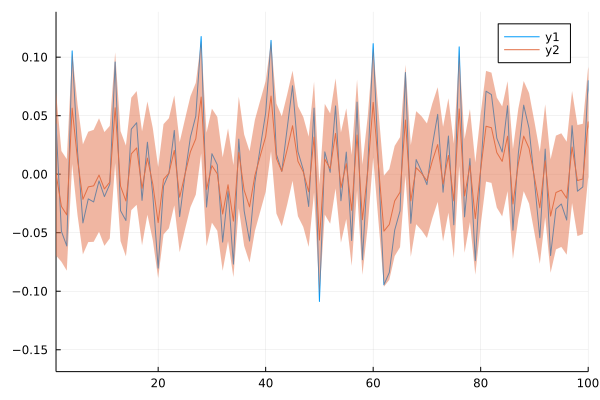

In [32]:
gr()
plot(noise_trn[2:end])
plot!(first.(mean.(e)), ribbon=sqrt.(first.(cov.(e))), xlims=(1, 100))

In [33]:
using DataStructures

threshold = 0.02
good_η_dict = SortedDict(η_true[findall(e -> abs(e) > threshold, η_true)] .=> findall(e -> abs(e) > threshold, η_true))

SortedDict{Float64, Int64, Base.Order.ForwardOrdering} with 5 entries:
  0.0238288 => 21
  0.0403178 => 22
  0.1       => 10
  0.136729  => 4
  0.726543  => 7

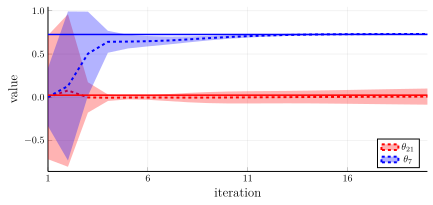

In [34]:
using LaTeXStrings
pgfplotsx()

real_θ = good_η_dict

pgfplotsx()
pθ = plot()
θms = mean.(η)
θvs = var.(η)

l = length(θms)

nums = (21, 7)

edim(e) = (a) -> map(r -> r[e], a)
colors_ = Dict(nums[1]=>"red", nums[2]=>"blue")
for (val, key) in zip(values(real_θ), keys(real_θ))
    if val == nums[1] || val == nums[2]
        plot!(pθ, θms |> edim(val), ribbon = θvs |> edim(val) .|> sqrt, linestyle=:dash, linewidth=2.0, label=L"\theta_{%$val}", fillalpha=0.3, color=colors_[val])
    end
end

for (val, key) in zip(values(real_θ), keys(real_θ))
    if val == nums[1] || val == nums[2]
        plot!(pθ, [ key ], seriestype = :hline, linewidth=1.5, label=false, color=colors_[val])
    end
end

plot!(size = (600, 300), legend=:bottomright, ylabel="value", xlabel="iteration",  ylabelfontsize=13, xlabelfontsize=13, legendfontsize=10, markeralpha=0.4, xtickfontsize=10, ytickfontsize=10, xticks=1:5:20, xlims=(1, 20))
# savefig(pθ, "../experiments/results/synthetic/inference_theta.tikz")



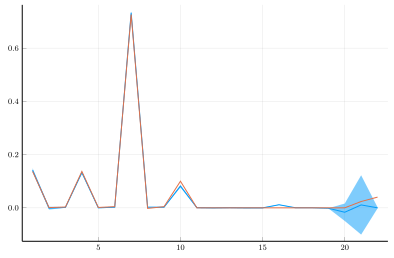

In [35]:
plot(mean(η[end]), ribbon=diag(std(η[end])), label=false)
plot!(η_true, label=false) 

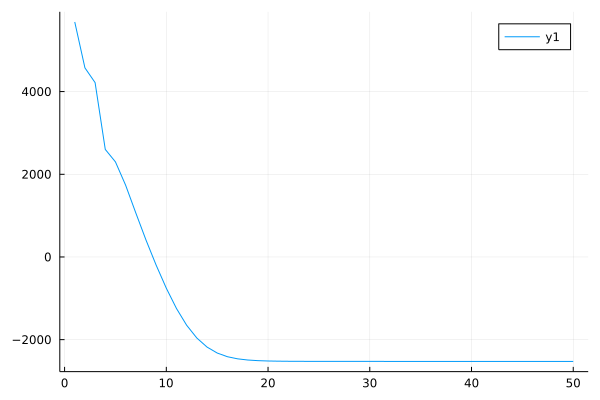

In [36]:
gr()
plot(fe[1:end])

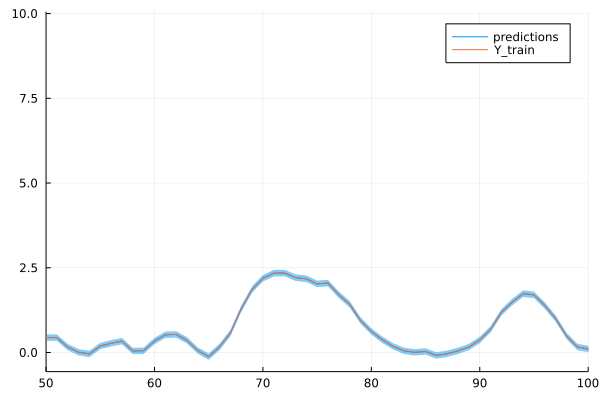

In [37]:
mfrom, mto = 50, 100
plot(first.(mean.(ẑ)) + mean.(e), ribbon=first.(sqrt.(cov.(ẑ))) + sqrt.(var.(e)), label="predictions")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

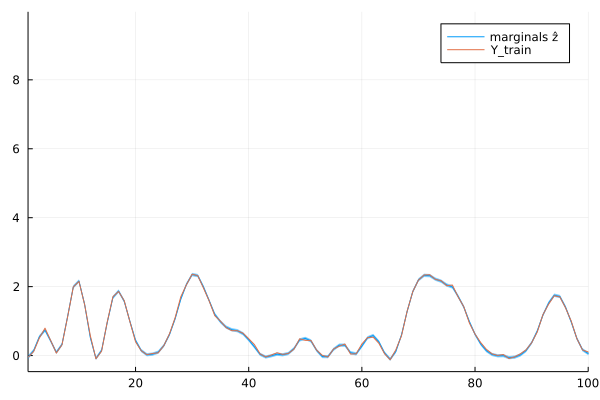

In [38]:
mfrom, mto = 1, 100
plot(first.(mean.(ẑ)), ribbon=first.(sqrt.(cov.(ẑ))), label="marginals ẑ")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

In [39]:
mean(w)

202.7660771989812

In [40]:
mean(τ)

251.56985609590384

## Prediction 

In [41]:
import NARMAXExperiments.prediction

function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, error)
    h_out = MvNormalMeanPrecision(mean(h_prior), precision(h_prior))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(UT(), phi_, y_prev, u))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (m_μ=PointMass(0.0), m_τ=PointMass(w_mle))
    
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=e_out)  
end

prediction (generic function with 2 methods)

In [42]:
# Nonlinear MAX model definition
@model function narmax_mini(h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_e, order)
        
    S = shift(delay_e); c = zeros(delay_e); c[1] = 1.0;
    h = randomvar()
    # initialize variables
    y  = datavar(Float64)
    # priors
    w  ~ GammaShapeRate(shape(w_prior), rate(w_prior))
    η  ~ MvNormalMeanPrecision(mean(η_prior), precision(η_prior))
    τ  ~ GammaShapeRate(shape(τ_prior), rate(τ_prior))
    # initial
    h_0  ~ MvNormalMeanPrecision(mean(h_prior), precision(h_prior))
    z ~ NonlinearNode(h_0) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi_, y_prev, u)}
    ẑ ~ AR(z, η, τ)
    e ~ NormalMeanPrecision(0.0, w)
    b = zeros(order); b[1] = 1.0;
    y ~ dot(b, ẑ) + e
    h ~ S*h_0 + c*e
    h ~ MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))

    return
end

In [43]:
import NARMAXExperiments.inference_callback

function inference_callback(h_prior, η_prior, τ_prior, w_prior, Y, X, U, delay_e, order)
    
    narmax_mini_model = Model(narmax_mini, h_prior, w_prior, η_prior, τ_prior, X, U, delay_e, full_order)

    mini_constraints = @constraints begin
        q(ẑ, z, η, τ, e, w, h_0, h) = q(ẑ, z, h_0, h)q(η)q(τ)q(e)q(w)
    end;

    mini_imarginals = (h_0 = h_prior,
                       w = w_prior,
                       τ = τ_prior,
                       η = η_prior);

    mini_imessages = (e = NormalMeanPrecision(0.0, 1.0), );
    
    mini_result = inference(
                    model = narmax_mini_model, 
                    data  = (y = Y, ),
                    constraints   = mini_constraints,
                    meta          = narmax_meta(Multivariate, full_order, ARsafe()),
                    initmarginals = mini_imarginals, 
                    initmessages  = mini_imessages,
                    returnvars    = (w=KeepLast(), e=KeepLast(), η=KeepLast(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast(), h_0=KeepLast(), h=KeepLast()),
                    free_energy   = true,
                    iterations    = 20, 
                    showprogress  = true
                );
    @unpack w, e, η, τ, z, ẑ, h_0, h = mini_result.posteriors
    w.data, e.data, η.data, τ.data, h.data
end

inference_callback (generic function with 2 methods)

In [44]:
predictions = []
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η[end].data

errors = []
ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_prior), η_prior, τ_prior, X_test[i], U_test[i], full_order=full_order, error=0.0)
    push!(predictions, pred)
    w_post, e_post, η_post, τ_post, h_post  = inference_callback(h_prior, η_prior, τ_prior, w_prior, Y_test[i], X_test[i], U_test[i], delay_e, full_order)
    h_prior = h_post
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
    push!(errors, e_post)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


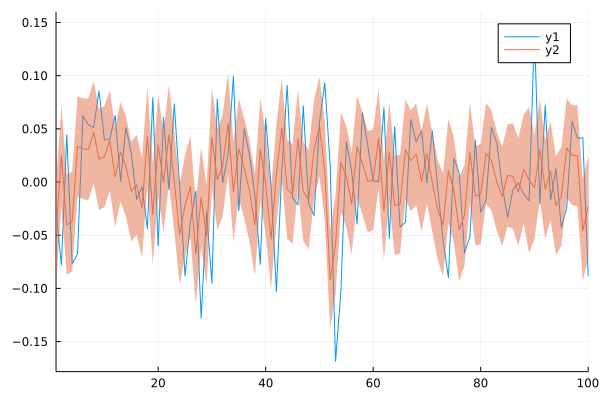

In [45]:
gr()
plot(noise_tst[end-length(errors)-1:end])
plot!(mean.(errors), ribbon=sqrt.(cov.(errors)), xlims=(1, 100))

In [46]:
errors;

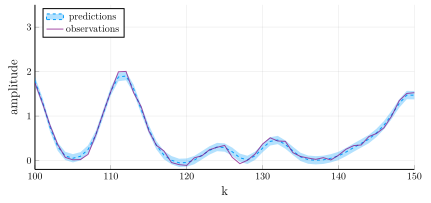

In [49]:
pgfplotsx()

pp = plot(mean.(predictions), ribbon=sqrt.(first.(var.(predictions))), fillalpha=0.3, linestyle=:dash, label="predictions", legend=:topleft, size=(600, 300), xlabel="k", ylabel="amplitude", )
plot!(Y_test, xlims=(100, 150), ylims=(-0.2, 3.5), label="observations", ylabelfontsize=13, xlabelfontsize=13, legendfontsize=10, markeralpha=0.3, xtickfontsize=10, ytickfontsize=10, color=:purple, width=1.0, alpha=0.7)
# savefig(pp, "../experiments/results/synthetic/predictions.tikz")

In [50]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.05076873458074514

# Simulation

In [51]:
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η[end].data

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
simulated_error = Vector{Any}([h_prior])

ProgressMeter.@showprogress for i in 1:length(Y_test)
    
    push!(simulated_X, [simulated_Y[i]; simulated_X[i][1:delay_y-1]])
    
    pred_sim = prediction(h_prior, mean(w_prior), η_prior, τ_prior, simulated_X[end], U_test[i], full_order=full_order, error=0.0)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))
    push!(simulated_error, h_prior)
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [52]:
RMSE = sqrt(mean((simulated_Y[2:end] .- Y_test).^2))

0.051358893693460445

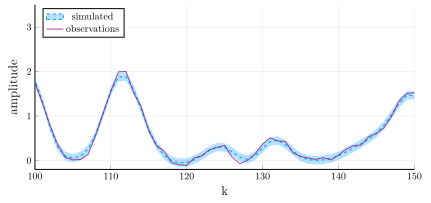

In [53]:
pgfplotsx()

ps = plot(simulated_Y[2:end], ribbon=sqrt.(simulated_Y_cov[2:end]), fillalpha=0.3, linestyle=:dash, label="simulated", legend=:topleft, size=(600, 300), xlabel="k", ylabel="amplitude")
plot!(Y_test, xlims=(100, 150), ylims=(-0.2, 3.5), label="observations", ylabelfontsize=13, xlabelfontsize=13, legendfontsize=10, markeralpha=0.3, xtickfontsize=10, ytickfontsize=10, color=:purple, width=1.0, alpha=0.7)
# savefig(ps, "../experiments/results/synthetic/simulations.tikz")

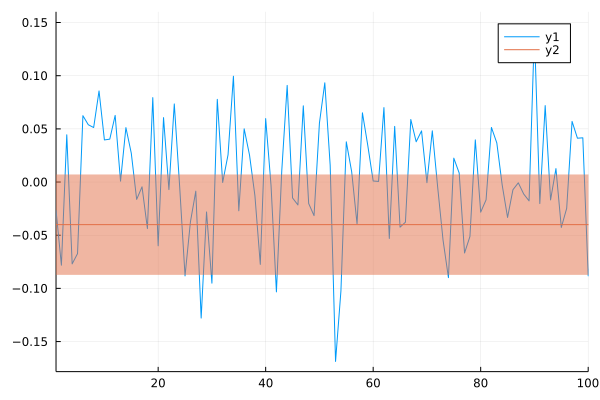

In [54]:
gr()
plot(noise_tst)
plot!(first.(mean.(simulated_error)), ribbon=first.(sqrt.(cov.(simulated_error))), xlims=(1, 100))